In [71]:
import fastf1 as ff1
from fastf1 import plotting
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
ff1.Cache.enable_cache('../cache')
pd.options.mode.chained_assignment = None

In [2]:
team = 'Alpine'
driver_1 = 'OCO'
driver_2 = 'GAS'

plt.style.use('dark_background')

In [3]:
event = ff1.get_event(2024, 6)

In [4]:
import os

# Set your desired directory path here
directory_path = "./" + str(event.year) + "/" + event.Location + "/qualifying"

# Create the directory if it doesn't exist
if not os.path.exists(directory_path):
    os.makedirs(directory_path)
    print(f"Directory '{directory_path}' was created.")
else:
    print(f"Directory '{directory_path}' already exists.")


Directory './2024/Miami/qualifying' was created.


In [5]:
q = event.get_qualifying()
q.load()

core           INFO 	Loading data for Miami Grand Prix - Qualifying [v3.3.0]
req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for _extended_timing_data. Loading data...
_api           INFO 	Fetching timing data...
_api           INFO 	Parsing timing data...
req            INFO 	D

In [6]:
corners = q.get_circuit_info().corners['Distance']

core        WARNING 	Failed to preserve data type for column 'X' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Y' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Z' while merging telemetry.


In [7]:
q.results.columns

Index(['DriverNumber', 'BroadcastName', 'Abbreviation', 'DriverId', 'TeamName',
       'TeamColor', 'TeamId', 'FirstName', 'LastName', 'FullName',
       'HeadshotUrl', 'CountryCode', 'Position', 'ClassifiedPosition',
       'GridPosition', 'Q1', 'Q2', 'Q3', 'Time', 'Status', 'Points'],
      dtype='object')

In [8]:
q.results[['Abbreviation', 'Q1', 'Q2']].sort_values('Q1').reset_index(drop=True)

,Abbreviation,Q1,Q2
0,VER,0 days 00:01:27.689000,0 days 00:01:27.566000
1,PER,0 days 00:01:27.772000,0 days 00:01:27.839000
2,NOR,0 days 00:01:27.913000,0 days 00:01:27.871000
3,SAI,0 days 00:01:27.937000,0 days 00:01:27.941000
4,GAS,0 days 00:01:27.976000,0 days 00:01:28.324000
5,PIA,0 days 00:01:28.032000,0 days 00:01:27.721000
6,LEC,0 days 00:01:28.081000,0 days 00:01:27.533000
7,RUS,0 days 00:01:28.159000,0 days 00:01:28.095000
8,HAM,0 days 00:01:28.167000,0 days 00:01:27.697000
9,STR,0 days 00:01:28.177000,0 days 00:01:28.222000


# Comparison of team drivers

### Functions

In [96]:
from typing import Tuple
from fastf1.core import Session, Laps, Telemetry
from fastf1 import utils
from pandas import Series

def filter_session(session: Session, session_number: int) -> Laps:
    '''Returns the laps in the session of the coresponding qualifying session'''
    if session_number == 1:
        return session.laps[
            (session.laps['Time'] < session._session_split_times[1])
            ]
    if session_number == 2:
        return session.laps[
            (session.laps['Time'] > session._session_split_times[1]) 
            & (session.laps['Time'] < session._session_split_times[2])
            ]
    if session_number == 3:
        return session.laps[
            (session.laps['Time'] > session._session_split_times[2])
            ]  
    raise ValueError("Qualifying session number must be between 1, 2 or 3")

def get_laptimes_qualifying(session: Session, driver:str) -> list[list[float]]:
    '''return the list of laptimes set during each qualifying sessions'''
    laptimes = []
    for i in range(1, 4):
        laptimes.append((filter_session(session, i).pick_driver(driver).pick_quicklaps()['LapTime'].dt.total_seconds()).to_list())
    return laptimes


def get_delta(driver_1: str, driver_2: str, laps: Laps) -> Tuple[Series, Telemetry, Telemetry]:
    '''Return the delta and telemetry for two selected drivers'''
    deltas, tel_d1, tel_d2 = utils.delta_time(
        laps.pick_driver(driver_1).pick_fastest(),
        laps.pick_driver(driver_2).pick_fastest()
    )
    tel_d1['Time'] = tel_d1['Time'].dt.total_seconds()
    tel_d2['Time'] = tel_d2['Time'].dt.total_seconds()
    return deltas, tel_d1, tel_d2

def get_axis_label(column):
    match column:
        case 'Speed':
            return 'Speed (km/h)'
        case 'Throttle':
            return 'Throttle pedal pressure (%)'
        case 'Brake':
            return 'Brakes applied or not'
        case _:
            return column

def plot_lap_telemetry_multi(datas, column, colors, labels, ax = None, min_distance = -np.Infinity, max_distance = np.Infinity, y_padding = 0, corner_numbers = True, file_name = None):
    if ax == None:
        ax = plt.subplot()
    
    for (i, data) in enumerate(datas):
        data = data[(data['Distance'] > min_distance) & (data['Distance'] < max_distance)]
        
        min_y = min(data[column] - y_padding)
        max_y = max(data[column] + y_padding)

        min_x = max(0, min_distance)
        max_x = min(max(data['Distance']), max_distance)

        ax.plot(
            data['Distance'],
            data[column],
            color=colors[i],
            linewidth=1,
            zorder=1,
            label = labels[i]
        )

    i = 0
    for corner_distance in corners:
        i += 1
        if (corner_distance < min_distance) | (corner_distance > max_distance):
            continue
        ax.vlines(corner_distance, min_y, max_y, linestyles='dashed', alpha=0.5)
        if corner_numbers:
            ax.text(
                corner_distance,
                max_y * 0.95,
                f'{i}',
                color='black',
                verticalalignment='top',
                horizontalalignment='center',
                bbox=dict(facecolor='white', alpha=1, boxstyle='circle', edgecolor='black')
                )

    ax.hlines(0, 0, max_x, zorder=-1, alpha=0.5)

    ax.grid(axis='y', linestyle='--', alpha=0.5)
    ax.set_xlim(min_x, max_x)
    ax.set_ylim(min_y, max_y)
    plt.legend(loc='lower right')
    ax.set_ylabel(get_axis_label(column))
    if file_name != None:
        plt.savefig(directory_path + '/' + file_name, bbox_inches = "tight")
    return ax

def plot_time_delta(ax, deltas, distances, labels, colors, min_distance = -np.Infinity, max_distance = np.Infinity, y_padding = 0, corner_numbers = True, file_name = None):
    max_i = len(distances)
    min_i = 0
    for i, distance in enumerate(distances):
        if distance > min_distance:
            min_i = i
            break
    for i, distance in enumerate(reversed(distances)):
        if distance < max_distance:
            max_i = len(distances) - i
            break
    
    min_y = min([min(delta[min_i: max_i]) for delta in deltas])
    max_y = max([max(delta[min_i: max_i]) for delta in deltas])

    min_x = max(min_distance, 0)
    for (i, delta) in enumerate(deltas):
        max_x = min(max(distances), max_distance)

        ax.plot(
            distances,
            delta,
            color=colors[i],
            linewidth=1,
            zorder=1,
            label=labels[i]
        )

    i = 1
    for corner_distance in corners:
        ax.vlines(corner_distance, min_y, max_y, linestyles='dashed', alpha=0.5)
        if corner_numbers:
            ax.text(
                corner_distance,
                max_y * 0.95,
                f'{i}',
                color='black',
                verticalalignment='top',
                horizontalalignment='center',
                bbox=dict(facecolor='white', alpha=1, boxstyle='circle', edgecolor='black')
                )
        i += 1

    ax.hlines(0, 0, max_x, zorder=-1, alpha=0.5)

    ax.grid(axis='y', linestyle='--', alpha=0.5)
    ax.set_xlabel('Distance (m)')
    ax.set_ylabel('Delta Time (s)')
    ax.set_xlim(min_x, max_x)
    ax.set_ylim(min_y - y_padding, max_y + y_padding)
    if file_name != None:
        plt.savefig(directory_path + '/' + file_name, bbox_inches = "tight") 
    return ax

def plot_telemetry(df, ref_team, others, min_distance = -np.Infinity, max_distance = np.Infinity, file_name = None, metric = 'Speed'):
    deltas = []
    distances = None
    telemetry = []
    colors = []
    labels = [ref_team] + others
    for (i, other) in enumerate(others):
        delta, t1, t2 = utils.delta_time(
            df.pick_team(ref_team).pick_fastest(),
            df.pick_team(other).pick_fastest()
        )
        if i == 0:
            telemetry.append(t1)
            distances = t1['Distance']
            colors.append(plotting.team_color(ref_team))
        deltas.append(delta)
        telemetry.append(t2)
        colors.append(plotting.team_color(other))

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10), sharex=True)
    ax1 = plot_lap_telemetry_multi(
        telemetry,
        metric,
        colors,
        labels,
        ax1,
        y_padding = 15,
        min_distance=min_distance,
        max_distance=max_distance)
    ax2 = plot_time_delta(
        ax2, deltas, distances, labels[1:], colors[1:], y_padding=0.1,
        corner_numbers=False, min_distance=min_distance,
        max_distance=max_distance
        )
    ax1.set_title('Comparison between bottom 5 teams')
    plt.legend(loc='lower right')
    if file_name != None:
        plt.savefig(directory_path + '/' + file_name, bbox_inches = "tight")
    plt.show()

def pedal_plot(telemetry, ax, min_distance = -np.Infinity, max_distance = np.Infinity):
    colors = [
        'red' if brake else 'green' if throttle == 100 else 'gray'
        for brake, throttle in zip(telemetry['Brake'], telemetry['Throttle'])
    ]
    # Previous end of rectangle (start at 0)
    prev_end = 0

    for i, (dist, color) in enumerate(zip(telemetry['Distance'], colors)):
        ax.fill_betweenx([0, 1], prev_end, prev_end + dist, color=color)
        prev_end += dist

    ax.set_xlim(max(min_distance, 0), min(max_distance, prev_end))
    ax.set_ylim(0, 1)
    ax.axis('off')
    return ax

def mul_pedal_plot(telemetry_list, ax, labels, min_distance = -np.Infinity, max_distance = np.Infinity):
    # Base y position and height for the rectangles, accounting for separation
    base_y = 0
    height = (1 - 0.05 * (len(telemetry_list) - 1)) / len(telemetry_list)

    for i, telemetry in enumerate(telemetry_list):
        colors = [
             'red' if brake
             else (0, throttle / 100, 0)
             for brake, throttle in zip(telemetry['Brake'], telemetry['Throttle'])
        ]
        # Previous end of rectangle (start at 0)
        prev_end = 0

        for dist, color in zip(telemetry['Distance'], colors):
            ax.fill_betweenx([base_y, base_y + height], prev_end, dist, color=color, alpha = 1)
            prev_end = dist

        # Label the dataset
        ax.text(max(min_distance, 0) - 15, base_y + height / 2, labels[i], va='center')

        if i < len(telemetry_list) - 1:
            ax.axhline(y=base_y + height + 0.025, color='white', linestyle='-', linewidth=0.5)

        # Move up the base y position for the next dataset, including separation
        base_y += height + 0.05
    ax.set_xlim(max(min_distance, 0), min(max_distance, prev_end))
    ax.set_ylim(0, 1)
    ax.axes.get_yaxis().set_visible(False)

def telemetry_comparison_with_delta(laps, d1, d2, c1, c2, title, columns, file_name = None, min_distance = -np.Infinity, max_distance = np.Infinity, figsize=(20,10)):
    delta, t1, t2 = utils.delta_time(
    laps.pick_driver(d1).pick_fastest(),
    laps.pick_driver(d2).pick_fastest()
    )

    deltas = [delta]
    distances = t1['Distance']
    telemetry = [t1, t2]
    colors = [c1, c2]
    labels = [d1, d2]

    height_ratio = [0.3 if column == 'Pedals' else 0.5 if column == 'nGear' else 1 for column in columns] + [1] # delta subplot
    
    fig, axes = plt.subplots(1 + len(columns), 1, figsize=figsize, sharex=True, height_ratios=height_ratio)
    if len(columns) == 0: # No columns so we don't have a collection of axes
        delta_ax = axes
        delta_ax.set_title(title)
    else:
        delta_ax = axes[-1]
        for i, ax in enumerate(axes[:-1]):
            if columns[i] == 'Pedals':
                ax = mul_pedal_plot(telemetry, ax, labels, min_distance=min_distance, max_distance=max_distance)
                continue
            ax = plot_lap_telemetry_multi(
                telemetry,
                columns[i],
                colors,
                labels,
                ax,
                y_padding = 5 if columns[i] != "nGear" else 0,
                min_distance=min_distance,
                max_distance=max_distance,
                corner_numbers= i == 0
                )
            ax.legend()
            axes[0].set_title(title)
    delta_ax = plot_time_delta(
        delta_ax, deltas, distances, labels[1:], colors[1:], y_padding=0.00,
        corner_numbers=len(columns) == 0, # Display number only if it's the only plot
        min_distance=min_distance,
        max_distance=max_distance
        )
    plt.legend(loc='lower right')
    if file_name != None:
        plt.savefig(directory_path + '/' + file_name, bbox_inches = "tight")
    plt.show()

### Parameters

In [ ]:
# Session to compare (Q1, Q2 or Q3)
q_session = 2

### Analysis

In [56]:
driver_1_laptimes = get_laptimes_qualifying(q, driver_1)
driver_2_laptimes = get_laptimes_qualifying(q, driver_2)

print('Laptimes')
for i in range(0, 3):
    print(f'--- Q{i + 1} ---')
    print(f'{driver_1} : ', driver_1_laptimes[i])
    print(f'{driver_2} : ', driver_2_laptimes[i])

Laptimes
--- Q1 ---
OCO :  [88.989, 88.385, 88.209]
GAS :  [89.132, 88.681, 87.976]
--- Q2 ---
OCO :  [88.371, 88.411]
GAS :  [88.324, 88.617]
--- Q3 ---
OCO :  []
GAS :  []


In [82]:
#deltas, tel_d1, tel_d2 = get_delta(driver_1, driver_2, filter_session(q, q_session))
q_analysis = filter_session(q, 2)

/usr/local/Caskroom/miniconda/base/envs/gpt/lib/python3.11/site-packages/fastf1/utils.py:91: FutureWarning: `utils.delta_time` is considered deprecated and willbe modified or removed in a future release because it hasa tendency to give inaccurate results.
  warnings.warn("`utils.delta_time` is considered deprecated and will"


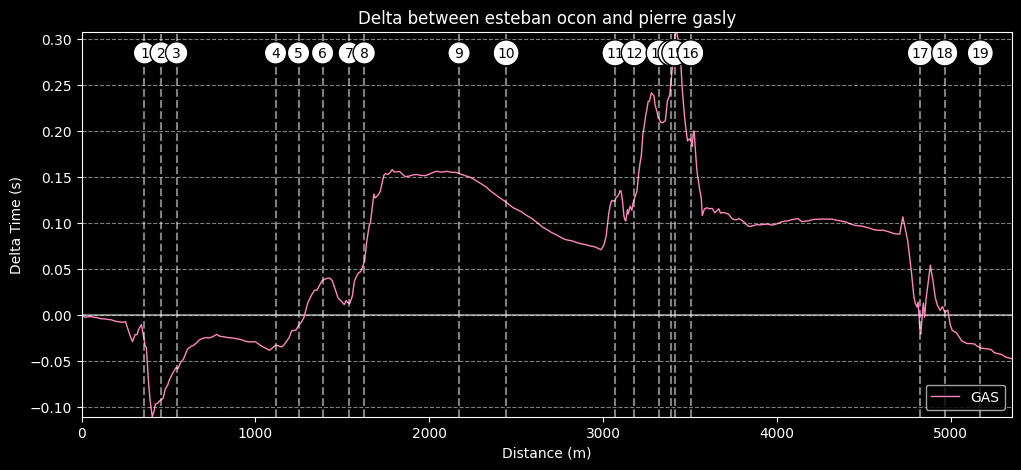

In [99]:
telemetry_comparison_with_delta(
    q_analysis,
    driver_1, driver_2, 
    'cornflowerblue', plotting.driver_color(driver_2), 
    f'Delta between {plotting.DRIVER_TRANSLATE[driver_1]} and {plotting.DRIVER_TRANSLATE[driver_2]}',
    [],
    file_name="delta",
    figsize=(12,5)
    )

/usr/local/Caskroom/miniconda/base/envs/gpt/lib/python3.11/site-packages/fastf1/utils.py:91: FutureWarning: `utils.delta_time` is considered deprecated and willbe modified or removed in a future release because it hasa tendency to give inaccurate results.
  warnings.warn("`utils.delta_time` is considered deprecated and will"
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


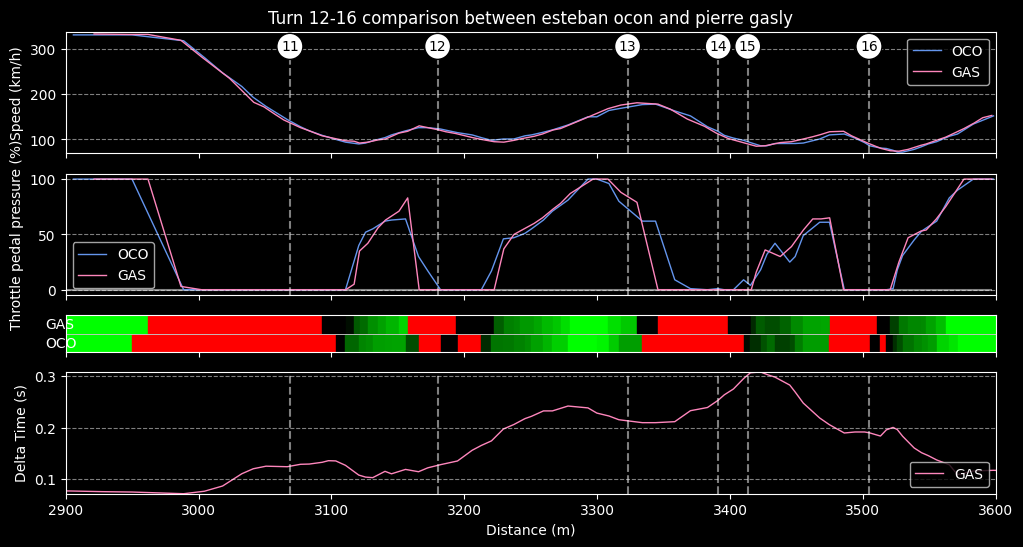

In [136]:
telemetry_comparison_with_delta(
    q_analysis,
    driver_1, driver_2, 
    'cornflowerblue', plotting.driver_color(driver_2), 
    f'Turn 12-16 comparison between {plotting.DRIVER_TRANSLATE[driver_1]} and {plotting.DRIVER_TRANSLATE[driver_2]}',
    ['Speed', 'Throttle', 'Pedals'],
    min_distance=2900,
    max_distance=3600,
    file_name="turn_12",
    figsize=(12,6)
    )

# Comparison between the team and others

In [145]:
q2_fastests_drivers = pd.DataFrame(
    [q_analysis.pick_team(t).pick_fastest() for t in q_analysis['Team'].unique() if t != team] +
        [
            q_analysis.pick_driver(driver_1).pick_fastest(),
            q_analysis.pick_driver(driver_2).pick_fastest()
        ]
)

q2_fastests_drivers.sort_values('LapTime', inplace=True)  
q2_fastests_drivers['LapTimeSeconds'] = q2_fastests_drivers['LapTime'].dt.total_seconds()
q2_fastests_drivers['S1'] = q2_fastests_drivers['Sector1Time'].dt.total_seconds()
q2_fastests_drivers['S2'] = q2_fastests_drivers['Sector2Time'].dt.total_seconds()
q2_fastests_drivers['S3'] = q2_fastests_drivers['Sector3Time'].dt.total_seconds()

q2_fastests_drivers['Color'] = q2_fastests_drivers['Team'].apply(plotting.team_color)

/var/folders/q1/q9_ky6lj68g7kv_5x5_pd9jw0000gp/T/ipykernel_1935/3749508433.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


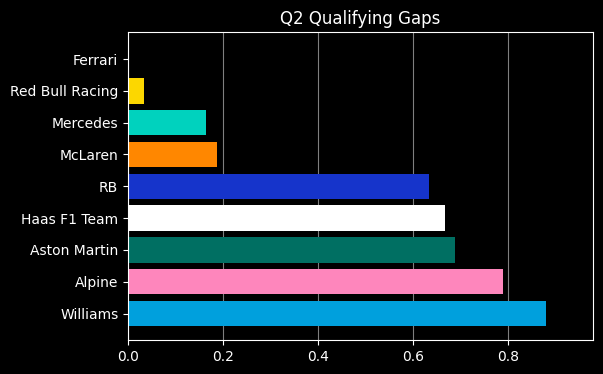

In [148]:
padding_right = 0.1
q_teams = q2_fastests_drivers.groupby('Team').first().reset_index().sort_values('LapTime')

q_teams['DeltaFastest'] = q_teams['LapTimeSeconds'] - q_teams.iloc[0]['LapTimeSeconds']

fig = plt.figure(figsize=(6, 4))
ax = plt.subplot()
plt.gca().invert_yaxis()

ax.barh(q_teams['Team'], q_teams['DeltaFastest'], color=q_teams['Color'], zorder=2)

ax.grid(axis='x', zorder=0, alpha=0.5)
ax.set_xlim(left=q_teams['DeltaFastest'].min(), right=q_teams['DeltaFastest'].max() + padding_right)
ax.set_title('Q2 Qualifying Gaps')
fig.savefig(directory_path + '/q2_gaps')
fig.show()

# Q1 to Q2 improvement

In [106]:
q1 = filter_session(q, 1)
q2 = filter_session(q, 2)

q2_improvements = pd.DataFrame(
    [(d, q2.pick_driver(d).pick_fastest()['LapTime'].total_seconds() - q1.pick_driver(d).pick_fastest()['LapTime'].total_seconds()) for d in q2['Driver'].unique()],
    columns=('Driver', 'Time')
)[0:15]
q2_improvements['Color'] = q2_improvements['Driver'].apply(plotting.driver_color)
q2_improvements.set_index('Driver', inplace=True)


/var/folders/q1/q9_ky6lj68g7kv_5x5_pd9jw0000gp/T/ipykernel_1935/52717273.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


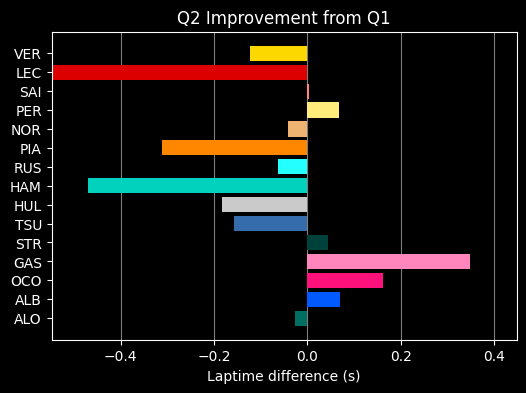

In [108]:
padding_right = 0.1
data = q2_improvements

fig = plt.figure(figsize=(6, 4))
ax = plt.subplot()
plt.gca().invert_yaxis()

ax.barh(data.index, data['Time'], color=data['Color'], zorder=2)

ax.grid(axis='x', zorder=0, alpha=0.5)
ax.set_xlim(left=data['Time'].min(), right=data['Time'].max() + padding_right)
ax.set_title('Q2 Improvement from Q1')
ax.set_xlabel('Laptime difference (s)')
fig.savefig(directory_path + '/q2_improvements')
fig.show()

In [334]:
q2_fastests_drivers = pd.DataFrame(
    [q2.pick_driver(d).pick_fastest() for d in q2['Driver'].unique()]
)

q2_fastests_drivers.sort_values('LapTime', inplace=True)  
q2_fastests_drivers['LapTimeSeconds'] = q2_fastests_drivers['LapTime'].dt.total_seconds()
q2_fastests_drivers['S1'] = q2_fastests_drivers['Sector1Time'].dt.total_seconds()
q2_fastests_drivers['S2'] = q2_fastests_drivers['Sector2Time'].dt.total_seconds()
q2_fastests_drivers['S3'] = q2_fastests_drivers['Sector3Time'].dt.total_seconds()

q2_fastests_drivers['Color'] = q2_fastests_drivers['Team'].apply(plotting.team_color)

/var/folders/q1/q9_ky6lj68g7kv_5x5_pd9jw0000gp/T/ipykernel_1935/454283324.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


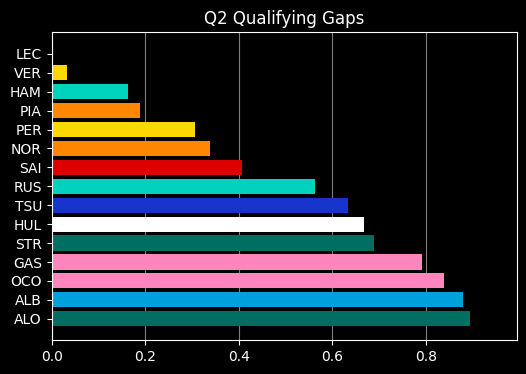

In [337]:
padding_right = 0.1
data = q2_fastests_drivers.groupby('Driver').first().reset_index().sort_values('LapTime')

data['DeltaFastest'] = data['LapTimeSeconds'] - data.iloc[0]['LapTimeSeconds']

fig = plt.figure(figsize=(6, 4))
ax = plt.subplot()
plt.gca().invert_yaxis()

ax.barh(data['Driver'], data['DeltaFastest'], color=data['Color'], zorder=2)

ax.grid(axis='x', zorder=0, alpha=0.5)
ax.set_xlim(left=data['DeltaFastest'].min(), right=data['DeltaFastest'].max() + padding_right)
ax.set_title('Q2 Qualifying Gaps')
fig.savefig(directory_path + '/q2_gaps_drivers')
fig.show()

# Comparison to others

In [371]:
fastest_sectors = q2.groupby('Driver')[['Sector1Time', 'Sector2Time', 'Sector3Time', 'Team']].min()
fastest_sectors['Sector1Time'] = fastest_sectors['Sector1Time'].dt.total_seconds()
fastest_sectors['Sector2Time'] = fastest_sectors['Sector2Time'].dt.total_seconds()
fastest_sectors['Sector3Time'] = fastest_sectors['Sector3Time'].dt.total_seconds()

fastest_sectors['Color'] = fastest_sectors['Team'].apply(plotting.team_color)
fastest_sectors.rename(
    columns= {
        'Sector1Time':'S1',
        'Sector2Time':'S2',
        'Sector3Time':'S3'
    },
    inplace=True
)
fastest_sectors = fastest_sectors.groupby('Team')[['S1', 'S2', 'S3', 'Color']].min()
fastest_sectors.reset_index(inplace=True)
fastest_sectors['Team'] = pd.Categorical(fastest_sectors['Team'], categories=q_teams['Team'].to_list(), ordered=True)
fastest_sectors.sort_values('Team', inplace=True)

/var/folders/q1/q9_ky6lj68g7kv_5x5_pd9jw0000gp/T/ipykernel_1935/2839362290.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


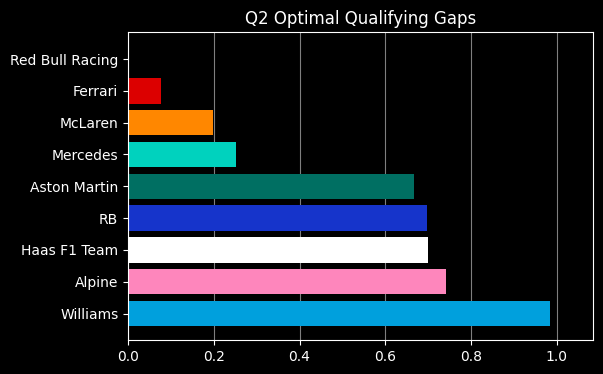

In [377]:
fastest_sectors['Optimal'] = fastest_sectors['S1'] + fastest_sectors['S2'] + fastest_sectors['S3']
fastest_sectors.sort_values('Optimal', inplace=True)
padding_right = 0.1

fastest_sectors['DeltaFastest'] = fastest_sectors['Optimal'] - fastest_sectors.iloc[0]['Optimal']

fig = plt.figure(figsize=(6, 4))
ax = plt.subplot()
plt.gca().invert_yaxis()

ax.barh(fastest_sectors['Team'], fastest_sectors['DeltaFastest'], color=fastest_sectors['Color'], zorder=2)

ax.grid(axis='x', zorder=0, alpha=0.5)
ax.set_xlim(left=fastest_sectors['DeltaFastest'].min(), right=fastest_sectors['DeltaFastest'].max() + padding_right)
ax.set_title('Q2 Optimal Qualifying Gaps')
fig.savefig(directory_path + '/q2_gaps_optimal')
fig.show()

In [378]:
team = 'Alpine'
compared_lap = fastest_sectors[fastest_sectors['Team'] == team].iloc[0]

fastest_sectors['S1Delta'] = fastest_sectors['S1'] - compared_lap['S1']
fastest_sectors['S2Delta'] = fastest_sectors['S2'] - compared_lap['S2']
fastest_sectors['S3Delta'] = fastest_sectors['S3'] - compared_lap['S3']

other_laps = fastest_sectors[fastest_sectors['Team'] != team]

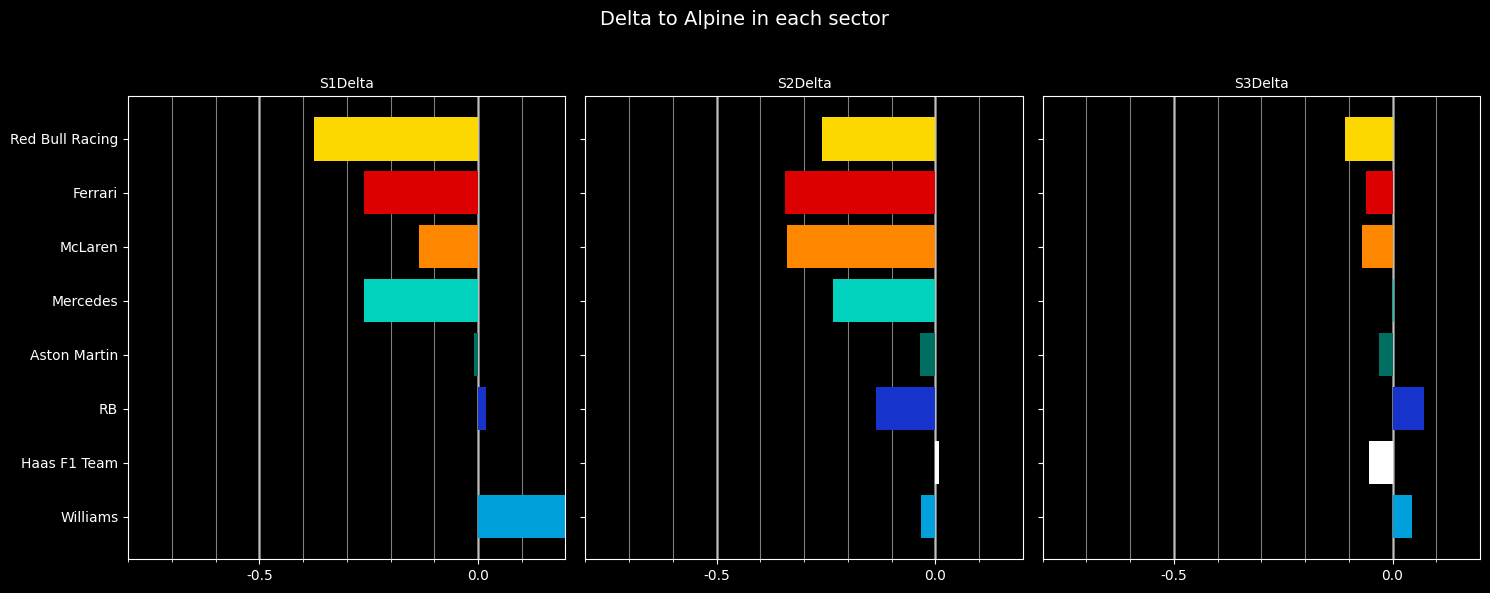

In [379]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np  # Ensure numpy is imported for arange function

# Assuming 'other_laps' is your DataFrame.

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(15, 6))  # Adjusted figsize for better visibility
plt.gca().invert_yaxis()

lim = (-0.8, 0.2)

def customize_axis(ax, lim, sector_name):
    ax.barh(other_laps['Team'], other_laps[sector_name], color=other_laps['Color'], zorder=2)
    ax.grid(axis='x', which='both', zorder=0, alpha=0.5)
    ax.set_xlim(lim)
    
    # Set major ticks
    major_ticks = [round(x, 2) for x in np.arange(-2, 2, 0.5) if x > lim[0] and x < lim[1]]
    minor_ticks = [round(x, 2) for x in np.arange(-2, 2, 0.1) if x > lim[0] and x < lim[1]]
    
    # Set major and minor locators
    ax.xaxis.set_major_locator(ticker.FixedLocator(major_ticks))
    ax.xaxis.set_minor_locator(ticker.FixedLocator(minor_ticks))
    
    # Generate dynamic labels for the major formatter
    major_labels = [f"{tick:.1f}" if tick in minor_ticks else "" for tick in major_ticks]
    ax.xaxis.set_major_formatter(ticker.FixedFormatter(major_labels))
    
    # Adding bolder lines at significant x values, e.g., x=0.5 and x=-0.5, within lim
    significant_xs = [x for x in major_ticks if lim[0] < x < lim[1]]
    for x in significant_xs:
        ax.axvline(x, color='grey', linewidth=2, zorder=1)  # Adjust color and linewidth as needed

    # Set subtitle for each axis
    ax.set_title(sector_name, fontsize=10)  # Adjust fontsize as needed

# Customize each axis with its name as subtitle
sectors = ['S1Delta', 'S2Delta', 'S3Delta']
for ax, sector_name in zip([ax1, ax2, ax3], sectors):
    customize_axis(ax, lim, sector_name)

# Set the overall title
fig.suptitle('Delta to Alpine in each sector', fontsize=14)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust the layout to make room for the overall title
plt.savefig(directory_path + '/q2_gaps_sector', bbox_inches = "tight")
plt.show()


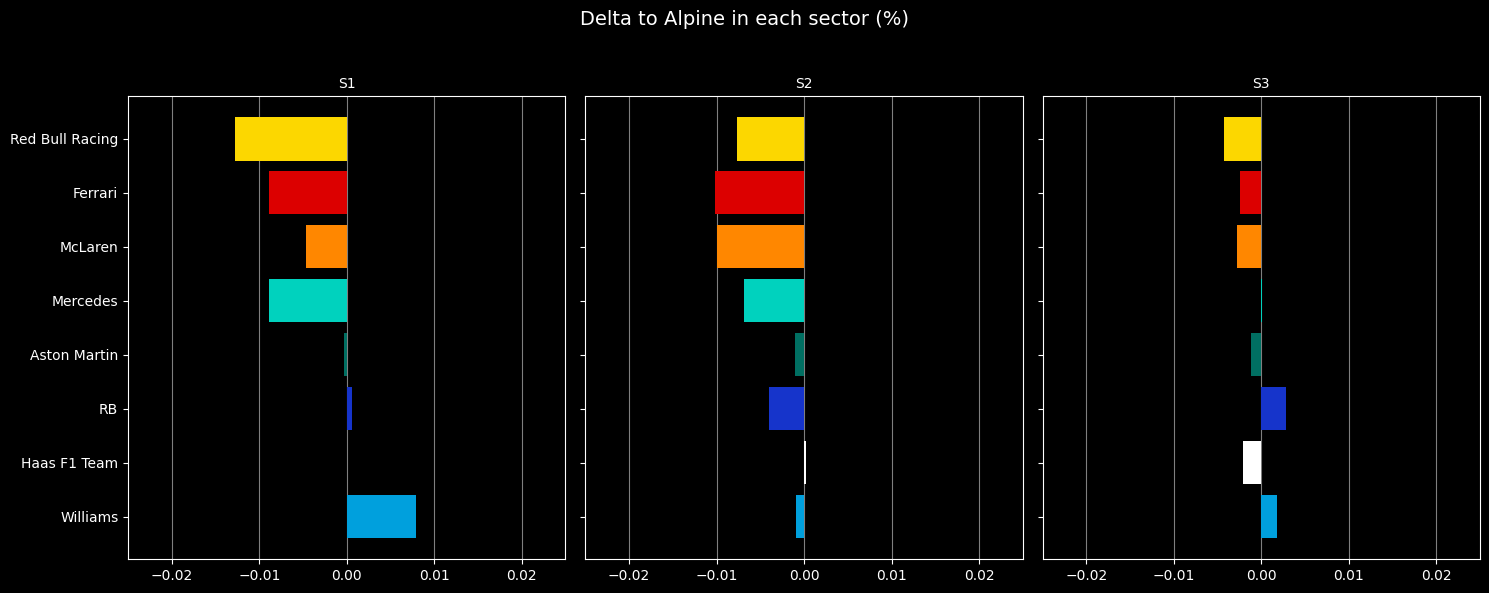

In [380]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np  # Ensure numpy is imported for arange function

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(15, 6))  # Adjusted figsize for better visibility
plt.gca().invert_yaxis()

lim = (-0.025, 0.025)

def customize_axis(ax, lim, sector_name):
    ax.barh(other_laps['Team'], other_laps[sector_name] / compared_lap[sector_name] - 1, color=other_laps['Color'], zorder=2)
    ax.grid(axis='x', which='both', zorder=0, alpha=0.5)
    ax.set_xlim(lim)
    
    # Set subtitle for each axis
    ax.set_title(sector_name, fontsize=10)  # Adjust fontsize as needed

# Customize each axis with its name as subtitle
sectors = ['S1', 'S2', 'S3']
for ax, sector_name in zip([ax1, ax2, ax3], sectors):
    customize_axis(ax, lim, sector_name)

# Set the overall title
fig.suptitle('Delta to Alpine in each sector (%)', fontsize=14)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust the layout to make room for the overall title
plt.savefig(directory_path + '/q2_gaps_sector_percent', bbox_inches = "tight")
plt.show()


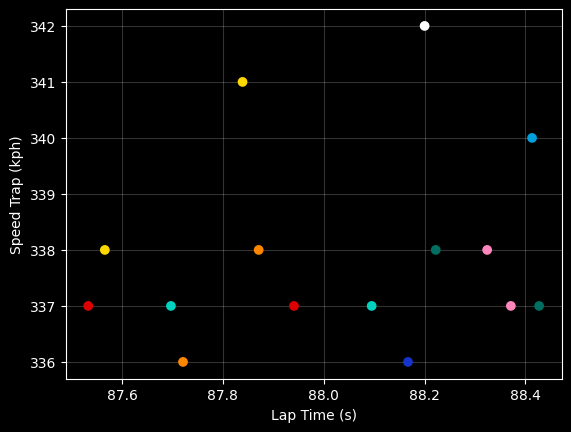

In [381]:
fig = plt.figure()
ax = plt.subplot()
ax.set_xlabel('Lap Time (s)')
ax.set_ylabel('Speed Trap (kph)')
ax.grid(alpha=0.2, zorder=0)
ax.scatter(q2_fastests_drivers['LapTimeSeconds'], q2_fastests_drivers['SpeedST'], color=q2_fastests_drivers['Color'], zorder=10)
plt.savefig(directory_path + '/top_speed', bbox_inches = "tight")

In [388]:
comparison_teams = ['Williams', 'Haas F1 Team', 'RB', 'Aston Martin']

/usr/local/Caskroom/miniconda/base/envs/gpt/lib/python3.11/site-packages/fastf1/utils.py:91: FutureWarning: `utils.delta_time` is considered deprecated and willbe modified or removed in a future release because it hasa tendency to give inaccurate results.
  warnings.warn("`utils.delta_time` is considered deprecated and will"
/usr/local/Caskroom/miniconda/base/envs/gpt/lib/python3.11/site-packages/fastf1/utils.py:91: FutureWarning: `utils.delta_time` is considered deprecated and willbe modified or removed in a future release because it hasa tendency to give inaccurate results.
  warnings.warn("`utils.delta_time` is considered deprecated and will"
/usr/local/Caskroom/miniconda/base/envs/gpt/lib/python3.11/site-packages/fastf1/utils.py:91: FutureWarning: `utils.delta_time` is considered deprecated and willbe modified or removed in a future release because it hasa tendency to give inaccurate results.
  warnings.warn("`utils.delta_time` is considered deprecated and will"
/usr/local/Caskroom

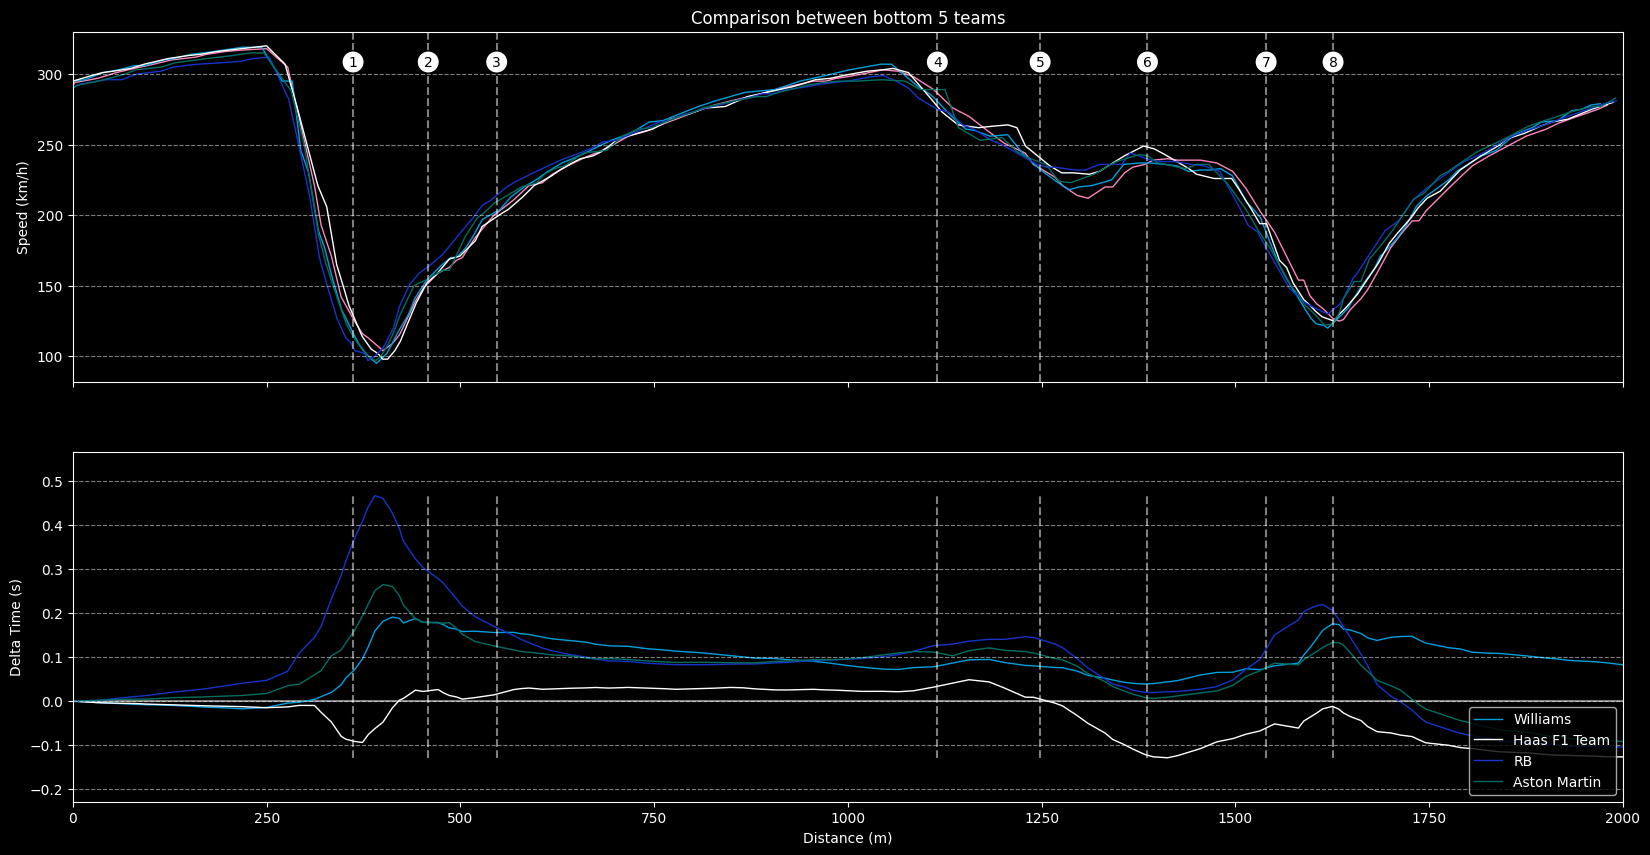

/usr/local/Caskroom/miniconda/base/envs/gpt/lib/python3.11/site-packages/fastf1/utils.py:91: FutureWarning: `utils.delta_time` is considered deprecated and willbe modified or removed in a future release because it hasa tendency to give inaccurate results.
  warnings.warn("`utils.delta_time` is considered deprecated and will"
/usr/local/Caskroom/miniconda/base/envs/gpt/lib/python3.11/site-packages/fastf1/utils.py:91: FutureWarning: `utils.delta_time` is considered deprecated and willbe modified or removed in a future release because it hasa tendency to give inaccurate results.
  warnings.warn("`utils.delta_time` is considered deprecated and will"
/usr/local/Caskroom/miniconda/base/envs/gpt/lib/python3.11/site-packages/fastf1/utils.py:91: FutureWarning: `utils.delta_time` is considered deprecated and willbe modified or removed in a future release because it hasa tendency to give inaccurate results.
  warnings.warn("`utils.delta_time` is considered deprecated and will"
/usr/local/Caskroom

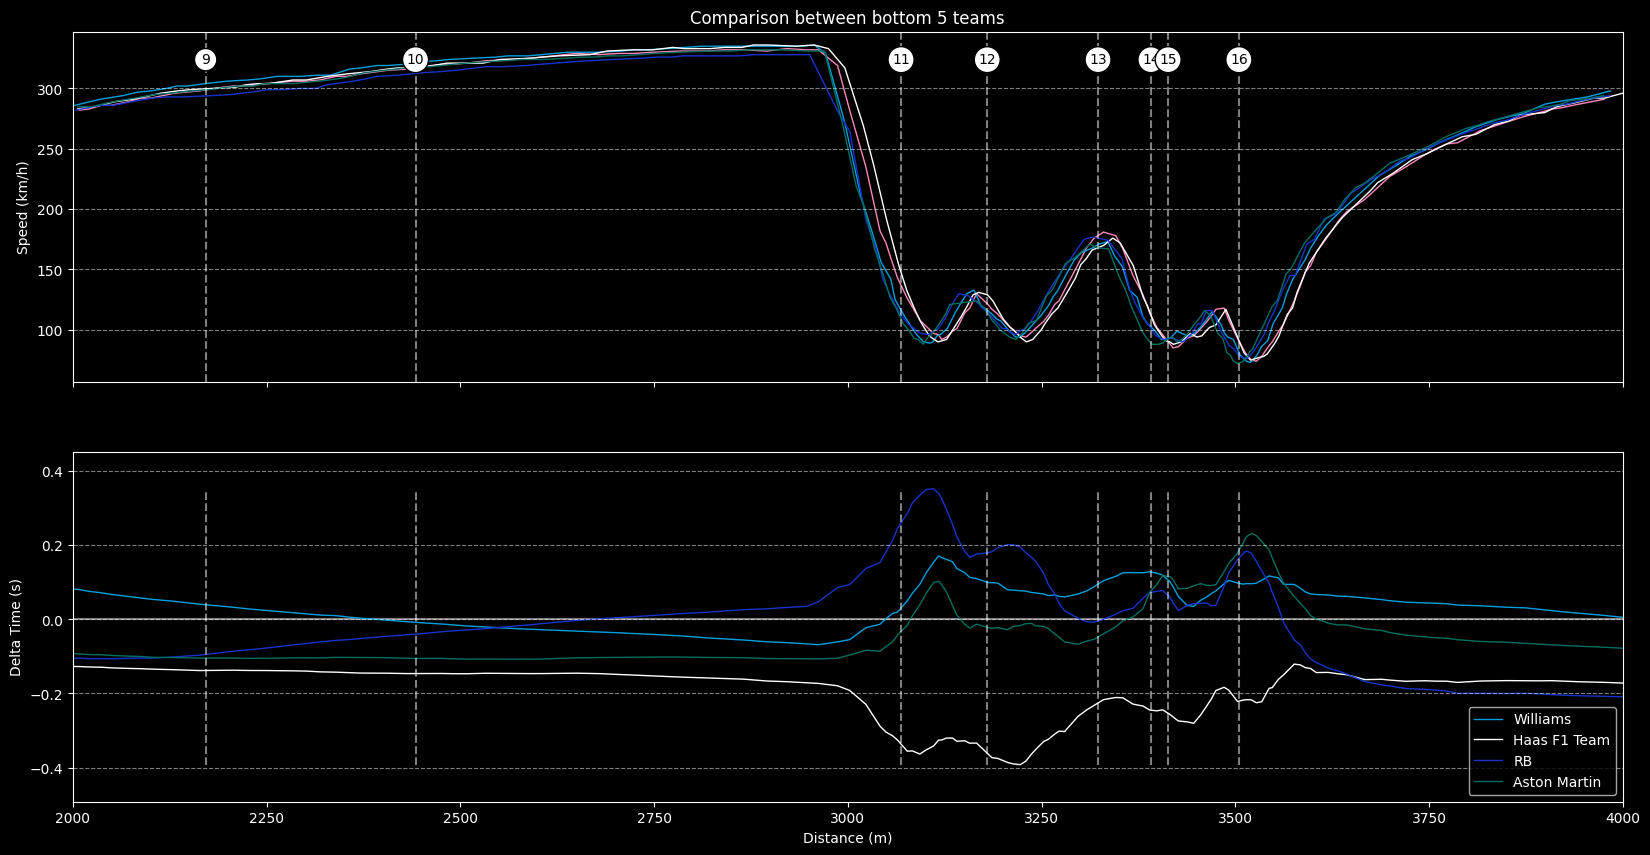

/usr/local/Caskroom/miniconda/base/envs/gpt/lib/python3.11/site-packages/fastf1/utils.py:91: FutureWarning: `utils.delta_time` is considered deprecated and willbe modified or removed in a future release because it hasa tendency to give inaccurate results.
  warnings.warn("`utils.delta_time` is considered deprecated and will"
/usr/local/Caskroom/miniconda/base/envs/gpt/lib/python3.11/site-packages/fastf1/utils.py:91: FutureWarning: `utils.delta_time` is considered deprecated and willbe modified or removed in a future release because it hasa tendency to give inaccurate results.
  warnings.warn("`utils.delta_time` is considered deprecated and will"
/usr/local/Caskroom/miniconda/base/envs/gpt/lib/python3.11/site-packages/fastf1/utils.py:91: FutureWarning: `utils.delta_time` is considered deprecated and willbe modified or removed in a future release because it hasa tendency to give inaccurate results.
  warnings.warn("`utils.delta_time` is considered deprecated and will"
/usr/local/Caskroom

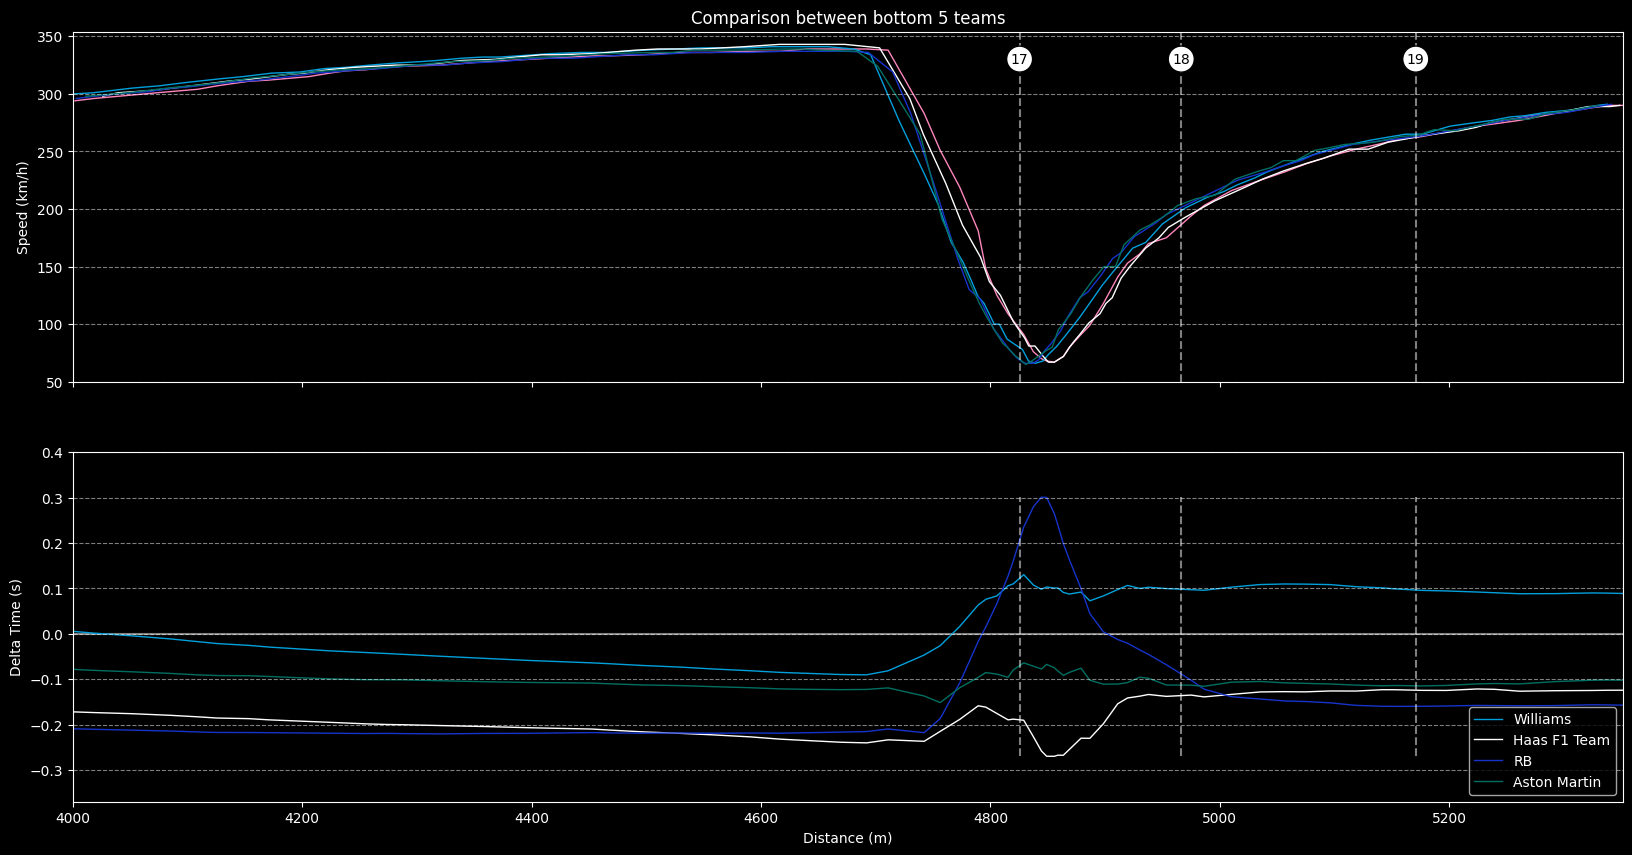

In [389]:
# Sector 1
plot_telemetry(
    q2,
    team,
    comparison_teams,
    max_distance=2000,
    file_name='telemetry_s1'
)
# Sector 2
plot_telemetry(
    q2,
    team,
    comparison_teams,
    min_distance=2000,
    max_distance=4000,
    file_name='telemetry_s2'
)
# Sector 3
plot_telemetry(
    q2,
    team,
    comparison_teams,
    min_distance=4000,
    file_name='telemetry_s3'
)

/usr/local/Caskroom/miniconda/base/envs/gpt/lib/python3.11/site-packages/fastf1/utils.py:91: FutureWarning: `utils.delta_time` is considered deprecated and willbe modified or removed in a future release because it hasa tendency to give inaccurate results.
  warnings.warn("`utils.delta_time` is considered deprecated and will"
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


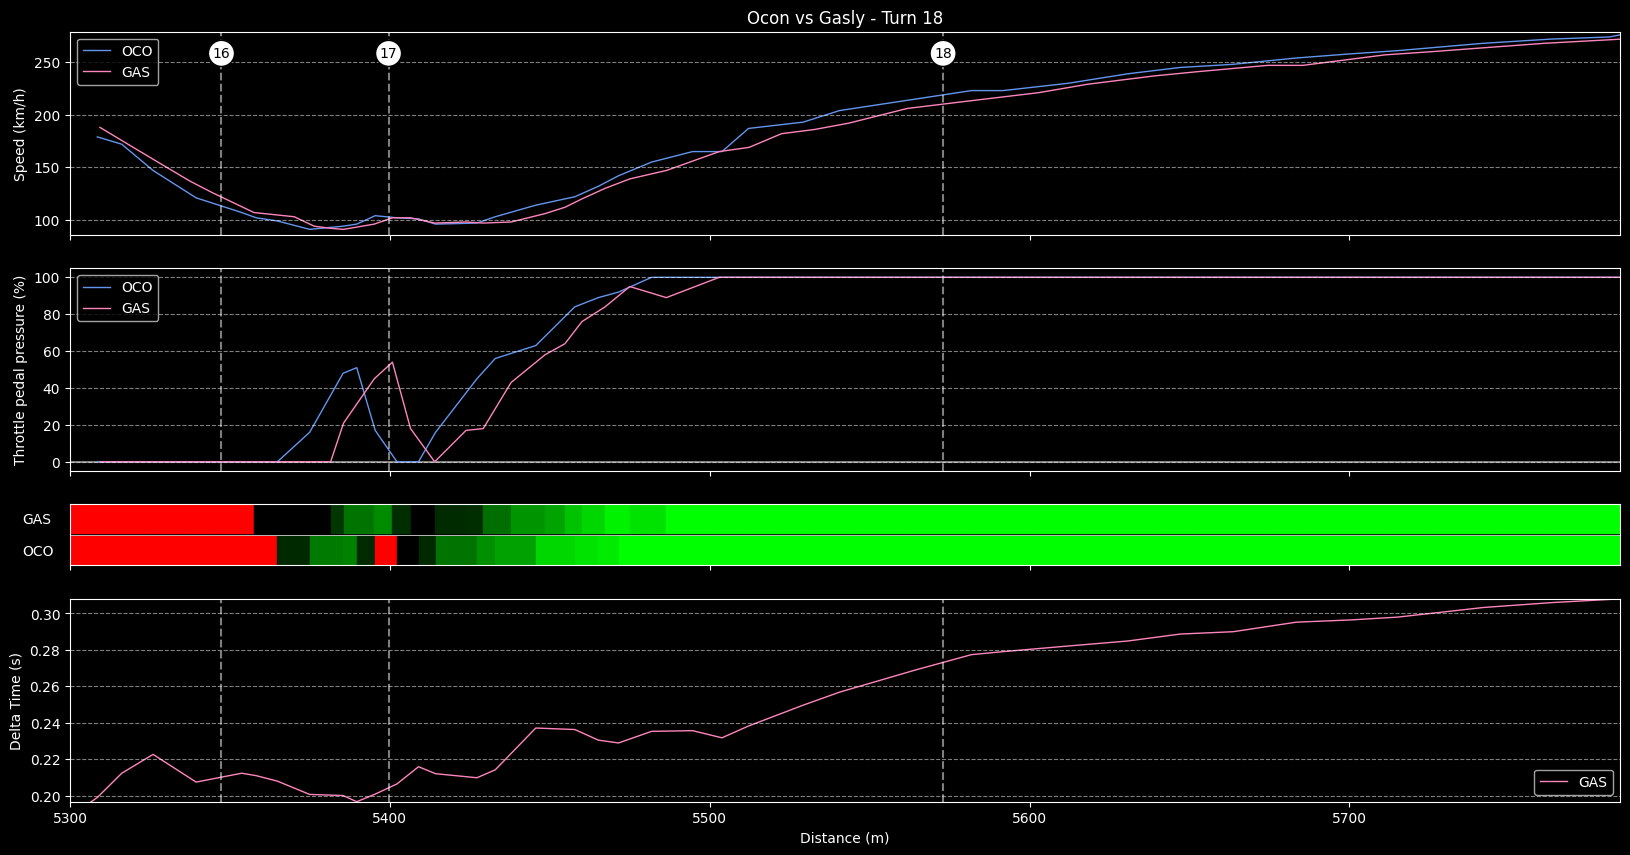

In [ ]:
telemetry_comparison_with_delta(
    driver_1, driver_2, 
    'cornflowerblue', plotting.driver_color(driver_2), 
    'Ocon vs Gasly - Turn 18',
    ['Speed', 'Throttle', 'Pedals'],
    min_distance=5300,
    max_distance=5800,
    file_name="turn_18"
    )

/usr/local/Caskroom/miniconda/base/envs/gpt/lib/python3.11/site-packages/fastf1/utils.py:91: FutureWarning: `utils.delta_time` is considered deprecated and willbe modified or removed in a future release because it hasa tendency to give inaccurate results.
  warnings.warn("`utils.delta_time` is considered deprecated and will"
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


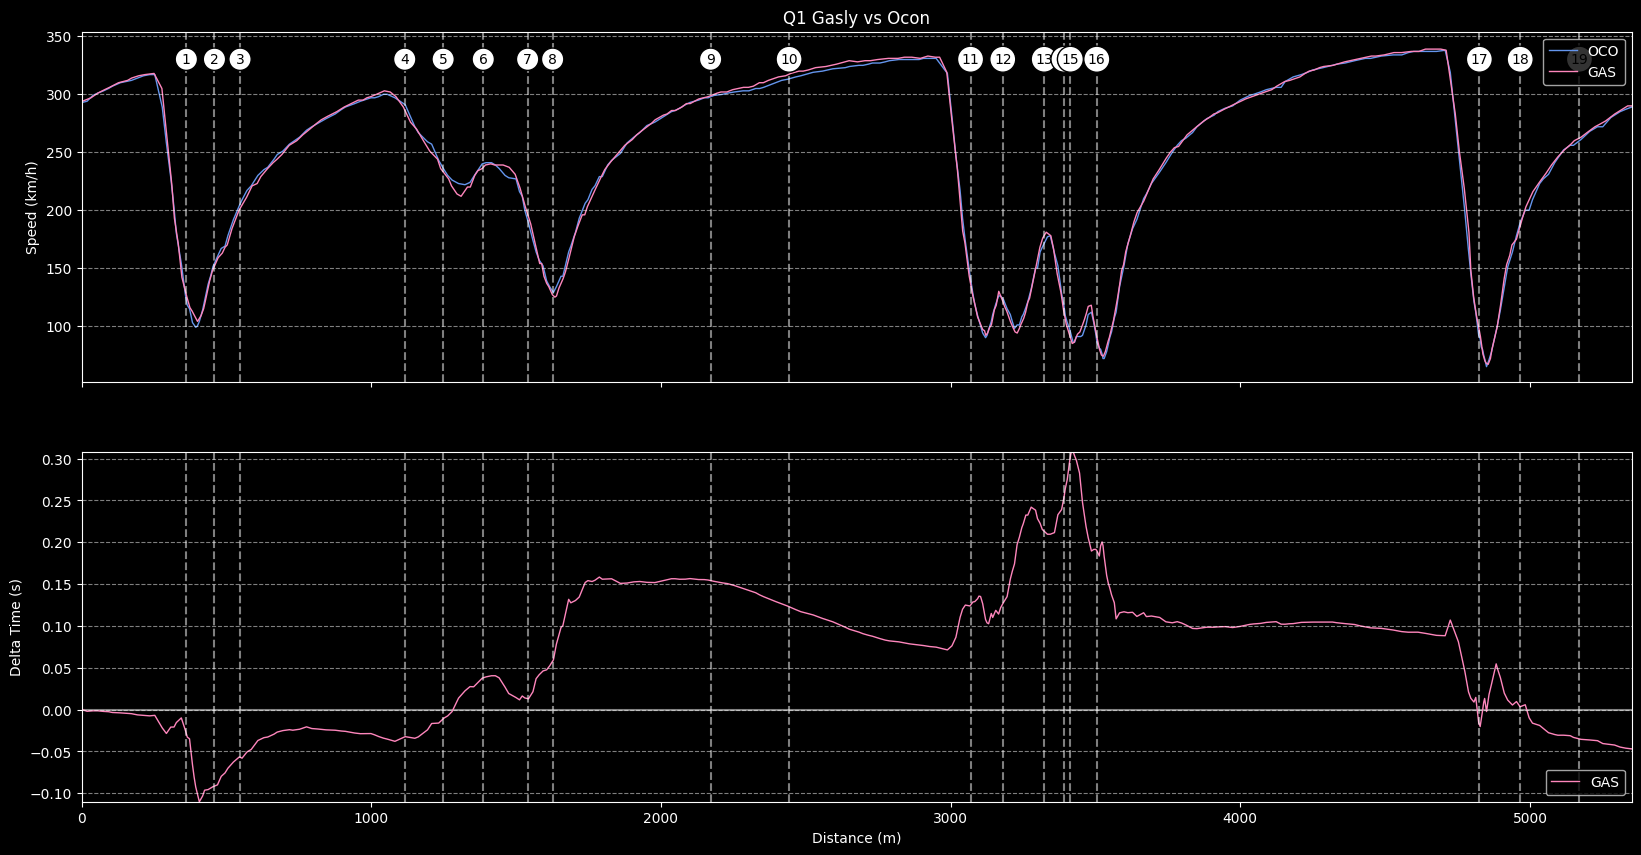

In [66]:
delta, t1, t2 = utils.delta_time(
    q1.pick_driver(driver_1).pick_fastest(),
    q1.pick_driver(driver_2).pick_fastest()
)

deltas = [delta]
distances = t1['Distance']
telemetry = [t1, t2]
colors = ['cornflowerblue', plotting.driver_color(driver_2)]
labels = [driver_1, driver_2]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10), sharex=True)
ax1 = plot_lap_telemetry_multi(
    telemetry,
    'Speed',
    colors,
    labels,
    ax1,
    y_padding = 15)
ax1.legend()
ax2 = plot_time_delta(
    ax2, deltas, distances, labels[1:], colors[1:], y_padding=0.0,
    corner_numbers=False
    )
ax1.set_title('Q1 Gasly vs Ocon')
plt.legend(loc='lower right')
plt.savefig(directory_path + '/q1_ocon_gasly_2', bbox_inches = "tight")
plt.show()

# Gaps over season

In [256]:
target_team = 'Alpine'
comparison_teams = ['Williams', 'Haas F1 Team', 'RB', 'Kick Sauber']

def get_qualy_gaps(session, target, comparisons):
    q = ff1.get_event(2024, 6).get_qualifying()
    q._load_drivers_results()
    target_drivers = session.results.query(f'TeamName == "{target}"')
    comparison_drivers = session.results.query(f'TeamName in {comparisons}').sort_values('Position').groupby('TeamName').first()[['Position', 'Q1', 'Q2', 'Q3']].sort_values('Position').drop(columns='Position')
    comparison_drivers['Q_diff'] = np.nan

    target_lap = None
    for i in reversed(range(1, 4)): # Search qualifying sessions starting by the end (Q3 -> Q1)
        session_laps = target_drivers[f'Q{i}'].dropna()
        if not session_laps.empty: # if there is a usable lap. Get the fastest
            target_lap = session_laps.sort_values()[0]
            comparison_drivers['Q_diff'] = comparison_drivers['Q_diff'].where(comparison_drivers['Q_diff'].notna(),
                                                                    (comparison_drivers[f'Q{i}'] - target_lap).dt.total_seconds())

    return comparison_drivers['Q_diff'].to_dict()


In [301]:
last_event = 6
target = 'Alpine'
comparison_teams = ['Williams', 'Haas F1 Team', 'RB', 'Kick Sauber']

gaps = pd.DataFrame(columns=['Event', 'Gaps'])
for i in range(1, last_event + 1):
    q = ff1.get_event(2024, i).get_qualifying()
    q._load_drivers_results()
    g = pd.DataFrame(columns=['Event', 'Gaps'])
    g['Gaps'] = get_qualy_gaps(q, target, comparison_teams) 
    g['Event'] = q.event.Location
    gaps = pd.concat([gaps, g])

gaps = gaps.rename_axis('Team').reset_index()
gaps['Gaps'] = -1 * gaps['Gaps']

req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for driver_info


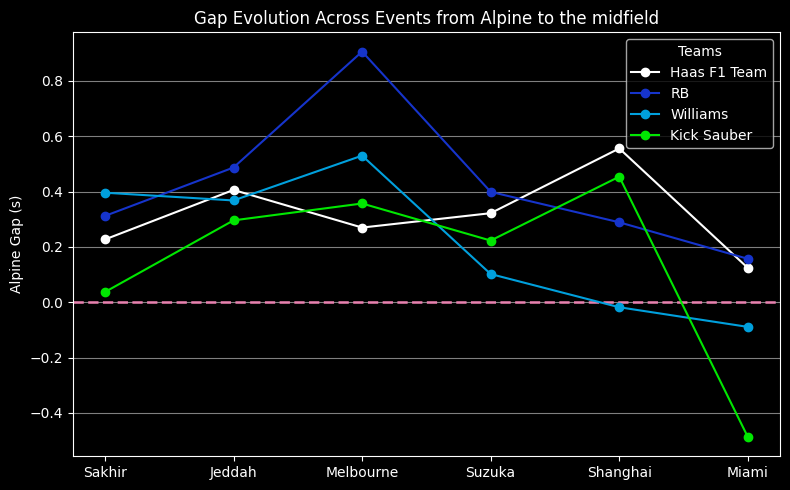

In [331]:
plt.figure(figsize=(8, 5))
plt.axhline(0, color=plotting.team_color(target), linewidth=2, linestyle='--', alpha=0.8)  # Adding a clearer zero line

for team in gaps['Team'].unique():
    team_data = gaps[gaps['Team'] == team]
    plt.plot(team_data['Event'], team_data['Gaps'], marker='o', label=team, color=plotting.team_color(team))

plt.title('Gap Evolution Across Events from Alpine to the midfield')
plt.ylabel('Alpine Gap (s)')
#plt.xticks(rotation=45)
plt.legend(title="Teams")
plt.grid(axis='y', alpha=0.5)
plt.tight_layout()
plt.savefig(directory_path + '/gaps_races', bbox_inches = "tight")
plt.show()
